# Visulise how the importance of a POD mode changes with latent variables
Plot the change as a contour plot for two latent variables, from a trained standard autoencoder.

In [1]:
import sys
sys.path.append('..')
import h5py
import numpy as np
from numpy import einsum
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import configparser
from pathlib import Path
from scipy import interpolate
from scipy.stats import gaussian_kde

import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()

import MD_AE_tools.models.models as mdl_bias
import MD_AE_tools.models.models_no_bias as mdl_nobias
from project_specific_utils.helpers import GetAttr
import MD_AE_tools.mode_decomposition as md
import MD_AE_tools.ae_mode_selection as ranking
import MD_AE_tools.ae_mode_evaluation as mode_eval
from project_specific_utils.data_and_train import TrainNN_from_config, train_autoencder
from project_specific_utils import plot as myplot

config = configparser.ConfigParser()
config.read('../_system.ini')
results_dir = config['system_info']['alternate_location']

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[1], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        tf.config.set_logical_device_configuration(gpus[1], [tf.config.LogicalDeviceConfiguration(memory_limit=2048)]) 
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# Load saved data

In [2]:
parent_folder = Path(results_dir,'experiment_standard_nonlinear')
# parent_folder = Path(results_dir,'experiment_linear_samedata')
!ls -v $parent_folder
folder_list = ! ls -v $parent_folder
# !tail -n 5 $parent_folder/*/log

/bin/bash: /home/ym917/miniconda3/envs/MD-CNN-AE/lib/libtinfo.so.6: no version information available (required by /bin/bash)
2mode-notregularised-1-954923  2mode-notregularised-5-954927
2mode-notregularised-2-954924  2mode-regularised-1-764454
2mode-notregularised-3-954925  2mode-regularised-2-764455
2mode-notregularised-4-954926  2mode-regularised-3-764456


In [3]:
folder = folder_list[6]
folder_path = Path(parent_folder,folder)
filename = Path(folder_path,'training_param.ini')
mdl_config = TrainNN_from_config(filename)

filename = Path(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_all = np.array(hf.get('u_all'))
    y_train = np.array(hf.get('y_train'))
    u_test = np.array(hf.get('u_test'))
    modes_train = np.array(hf.get('modes_train'))
    modes_test = np.array(hf.get('modes_test'))
    latent_train = np.array(hf.get('latent_train'))
    latent_test = np.array(hf.get('latent_test'))

    u_test_mean = np.array(hf.get('u_avg_test'))

print('MSE of traning is: ', mse(u_train,y_train).numpy())

MSE of traning is:  1.1748656


2023-06-05 18:47:43.920366: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 18:47:44.809302: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2048 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:73:00.0, compute capability: 7.5


In [4]:
# ============= For ff_ae ==================

from project_specific_utils.ff_ae import Train_ff_ae
folder = folder_list[1]
folder_path = Path(parent_folder,folder)
filename = Path(folder_path,'training_param.ini')
model_class = Train_ff_ae()
mdl_config = model_class.import_config(filename)

with h5py.File(Path('../data/ufluc_shuffle_1632'),'r') as hf:
    u_all = np.squeeze(np.array(hf.get('u_all'))).astype('float32')

KeyError: 'cut_off'

Calculating POD ...
Use classic POD, Nx <= Nt.


/home/ym917/Codes/MD-CNN-AE/notebook_visualise/../MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


POD done.
MSE reconstructed with 2 modes is:  1.4855965375900269


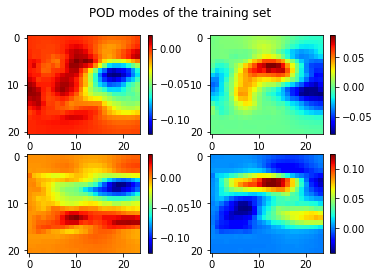

In [5]:
# data 
x = einsum('t y z u -> y z t u',np.squeeze(u_all))
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
pod = md.POD(X)
Q_POD,lam_data = pod.get_modes
Q_mean = pod.Q_mean
X_reconstructed = pod.reconstruct(2,shape=X.shape)
print('MSE reconstructed with 2 modes is: ', mse(X,X_reconstructed).numpy())

phi1 = Q_POD[:,0].reshape((42,24))
phi2 = Q_POD[:,1].reshape((42,24))
fig = plt.figure()
fig.suptitle('POD modes of the training set')
plt.subplot(221)
plt.imshow(phi1[:21,:],'jet')
plt.colorbar()
plt.subplot(223)
plt.imshow(phi1[21:,:],'jet')
plt.colorbar()
plt.subplot(222)
plt.imshow(phi2[:21,:],'jet')
plt.colorbar()
plt.subplot(224)
plt.imshow(phi2[21:,:],'jet')
plt.colorbar()

# x_test = einsum('t y z u -> y z t u',np.squeeze(u_test))
# X_test = np.vstack((x_test[:,:,:,0],x_test[:,:,:,1]))
# pod_test = md.POD(X_test,method='classic')
# A_test = pod_test.get_time_coefficient
# Q_POD_test, lam_data_test = pod_test.get_modes

plt.show()

# How b varies with z1 and z2
Cannot visualise the full effect if b depends on more than two variables.

In [6]:
from MD_AE_tools.models import model_evaluation
from tensorflow.keras.optimizers import Adam

In [7]:
mdl = mdl_nobias.Autoencoder(Nx=mdl_config.Nx,Nu=mdl_config.Nu,
                            features_layers=mdl_config.features_layers,
                            latent_dim=mdl_config.latent_dim,
                            filter_window=mdl_config.filter_window,
                            act_fct=mdl_config.act_fct,
                            batch_norm=mdl_config.BATCH_NORM,
                            drop_rate=mdl_config.drop_rate,
                            lmb=mdl_config.lmb,
                            resize_meth=mdl_config.resize_meth)
mdl.compile(optimizer=Adam(learning_rate=mdl_config.learning_rate),loss='mse')
mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

# ==============================================
filename = Path(folder_path,'md_ae_model.h5')
mdl.load_weights(filename)
mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

# ===============================================
decoder = mdl.decoder

2023-06-05 18:47:50.149479: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


51/51 [==============================] - 0s 6ms/step - loss: 1.2657


In [ ]:
# ============= For ff_ae =============================
filename = Path(folder_path,'weights.h5')
model_class.make_model()
mdl = model_class.get_model
mdl.summary()
mdl.load_weights(filename)

In [8]:
gridx,gridy = (1001,1001)
z1 = np.linspace(-0.8,0.8,gridx).astype('float32')
z2 = np.linspace(-0.8,0.8,gridy).astype('float32')
idx_z2_0 = np.squeeze(np.argwhere(np.abs(z2-0)<1.19209e-07))
print(idx_z2_0)
zx,zy = np.meshgrid(z1,z2)

500


In [ ]:
### compute derivatives in batches
batch_size = 60
dy_dz = []

# hold z1 constant, change z2
for i in range(len(z1)):
    dy_dz_i = []
    t = 0
    # for j in range(len(z2)):
    while (t+batch_size) < len(z2):

        # print(f'in this batch t={t} to {t+batch_size}')
        # print(tf.stack([zx[t:t+batch_size,i],zy[t:t+batch_size,0]],axis=1)[:3,...])

        gradients = model_evaluation.get_gradient_m_z(
            tf.stack([zx[t:t+batch_size,i],zy[t:t+batch_size,0]],axis=1),
            decoder
        ) # [batch,....,z]

        dy_dz_i.append(gradients)

        t = t + batch_size
    
    # print(f'in this batch t={t} to {len(z2)}')
    gradients = model_evaluation.get_gradient_m_z(tf.stack([zx[t:,0],zy[t:,0]],axis=1),decoder) 

    dy_dz_i.append(gradients)

    dy_dz.append(np.vstack(dy_dz_i))

dy_dz = np.array(dy_dz) # (no.of z1, z2, ny, nz, nu, latent_dim)

In [ ]:
# np.save('noregularisation3.npy',dy_dz)

In [9]:
# dy_dz = np.load('noregularisation5.npy')
dy_dz = np.load('regularisation1.npy')

In [10]:
def get_dB_dz(dy_dz,pod_modes):
    dy_dz_vector = []
    dy_dz_temp = einsum('k t y z u -> k y z t u', dy_dz) # rearrange the same way as preparing for pod

    for i in range(dy_dz.shape[0]):
        dy_dz_reshape = np.vstack((dy_dz_temp[i,:,:,:,0], dy_dz_temp[i,:,:,:,1]))
        dy_dz_reshape = np.reshape(dy_dz_reshape,(-1, dy_dz.shape[1]))
        dy_dz_vector.append(dy_dz_reshape)

    dy_dz_vector = np.array(dy_dz_vector) # shape[no of z1,modes,no of z2]

    dB_dz = []
    for i in range(dy_dz.shape[0]):
        dB_dz.append(pod_modes.T @ dy_dz_vector[i,...])
    dB_dz = np.array(dB_dz) # [no of z1, modes, no of z2]
    
    return dB_dz

In [11]:
dB_dz1 = get_dB_dz(dy_dz=dy_dz[...,0],pod_modes=Q_POD)
dB_dz2 = get_dB_dz(dy_dz=dy_dz[...,1],pod_modes=Q_POD)
dB_dz1.shape

(1001, 1008, 1001)

## Reference values
Check the results from both post processing and gradents matches

(1001, 21, 24, 2)
(1001, 1008)


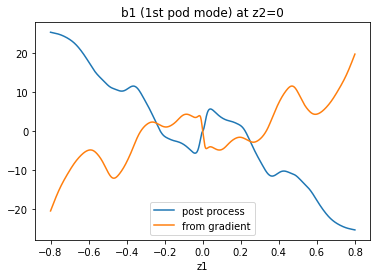

In [12]:
## predict z2 = 0
m = 0
z1_z2_0 = np.stack([zx[0,:],zy[idx_z2_0,:]],axis=1)
ref_ae_modes = mdl.decoder.predict(z1_z2_0)
print(ref_ae_modes.shape)


x_train = einsum('t y z u -> y z t u', ref_ae_modes)
b0_ref = []

X_train = np.vstack((x_train[:,:,:,0], x_train[:,:,:,1]))
X_train = np.reshape(X_train,(-1, len(z1)))
b0_ref = einsum('x t, x m -> t m', X_train, Q_POD)
print(b0_ref.shape) # [no of z1, no of pod modes]

b0 = model_evaluation.one_step_integrate(z1,dB_dz1[:,m,idx_z2_0],0,0,z1[1]-z1[0])

plt.figure()
plt.plot(z1,b0_ref[:,m],label='post process')
plt.plot(z1,b0,label='from gradient')
plt.title(f'b{m+1} ({m+1}st pod mode) at z2=0')
plt.legend()
plt.xlabel('z1')
plt.show()


## Calculate from gradients
First, calculate b(z1,0), which is b(z1,z2) at z2 = 0, by integrating (db/dz1) at z2 = 0

In [13]:
b0 = model_evaluation.one_step_integrate(z1,dB_dz1[:,0,idx_z2_0],0,0,z1[1]-z1[0])

B0 = []
for i in range(10):
    B0.append(
      model_evaluation.one_step_integrate(z1,dB_dz1[:,i,idx_z2_0],0,0,z1[1]-z1[0])
    )
B0 = np.array(B0)
B0.shape # [pod mode, no of z1 points]

(10, 1001)

Now calculate b(z1,z2) at different z1, using b(z1,0) calculated in the last step as the initial condition.

(1001, 1001)


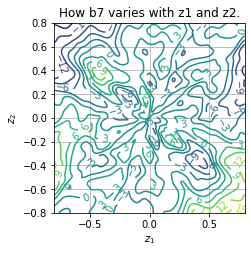

(1001, 1001)


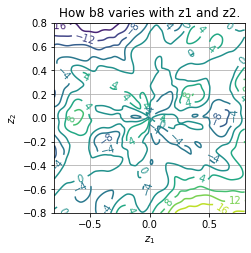

(1001, 1001)


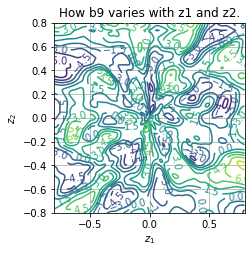

(1001, 1001)


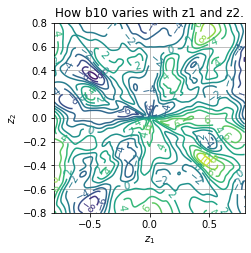

In [27]:
# for which_pod_mode_b in [6,7,8,9]:
for which_pod_mode_b in [0,1,2,3]:
    # which_pod_mode_b = 0
    B_grad = []
    for i in range(len(z1)):
        B_perz2 = model_evaluation.one_step_integrate(
            z2, dB_dz2[i,which_pod_mode_b,:], 0, B0[which_pod_mode_b,i], z2[1]-z2[0]
        )
        B_grad.append(B_perz2)
    B_grad = np.array(B_grad)
    print(B_grad.shape)


    plt.figure(figsize=(4,3.5))
    ax = plt.subplot(111,aspect=(max(z2)-min(z2))/(max(z1)-min(z1)))
    cs = ax.contour(zx,zy,B_grad.T,levels=10)
    # plt.colorbar(cs,ax=ax)
    plt.clabel(cs)
    plt.title(f'How b{which_pod_mode_b+1} varies with z1 and z2.')
    plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.grid()
    # plt.savefig(f'b{which_pod_mode_b+1}.pdf')
    plt.show()

How much $B_j$ varies with $z_i$.

$\int \int | \frac{dB_j}{dz_i}| dz_1 dz_2 / (range(z_1) \times range(z_2))$

when calculating with discrete values and equal intervals, this is 

$\epsilon = \sum_{z_1,z_2} | \frac{dB_j}{dz_i} | / (N_{z_1} N_{z_2})$
average absolute rate of change of decoder coefficients due to the latent variables 

In [15]:
avgbz1 = np.mean(np.abs(dB_dz1),(0,2))
avgbz2 = np.mean(np.abs(dB_dz2),(0,2))

[58.28241004 39.14335668 60.85280948 51.52850241] [59.00717335 41.76804652 64.18295512 44.83184729]


/tmp/ipykernel_2660734/1607521170.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticks=[], xticklabels=[0,1,2,3,4,5,6,7,8])


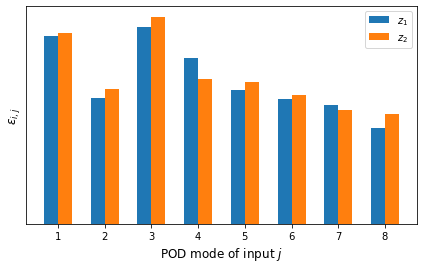

In [26]:
print(avgbz1[:4],avgbz2[:4])
fig,ax = plt.subplots(figsize=(7,4))
ax.bar(np.arange(1,9)-0.15,avgbz1[:8],width=0.3,label='$z_1$')
ax.bar(np.arange(1,9)+0.15,avgbz2[:8],width=0.3,label='$z_2$')
ax.set(yticks=[], xticklabels=[0,1,2,3,4,5,6,7,8])
ax.set_ylabel(ylabel='$\epsilon_{i,j}$',fontsize='large')
ax.set_xlabel(xlabel='POD mode of input $j$',fontsize='large')
ax.legend()
# plt.show()
plt.savefig('averged_absolute_rate_of_change_stadnardae.pdf')